In [1]:
# Set up the notebook before running multiple instances
# Figure 3: All false
# Figure 4: weather_variables = True
# Table 1: seasonal = True
# Figure 5.a: distance = True
# Figure 5.b: distance = True, weather_variables = True
weather_variables = True
distance = False
seasonal = False

In [2]:
system_id = 0
kilometers = 0
year = 2021
month = 'jan'
months = {'jan':0,'feb':1, 'mar':2, 'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':'9','nov':10,'dec':11}

In [3]:
# Base library imports
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt

# SolNet imports
from src.util import formulas as fm
from src.data.datafetcher import PvFetcher
from src.data.featurisation import Featurisation
from src.util.open_meteo_api import Open_meteo
from src.util.dwd_data_prep import Weather_data
from src.tensors.tensorisation import Tensors
from src.models.lstm import LSTM
from src.models.training import Training
from src.models.training import save_model
from src.evaluation.evaluation import Evaluation

In [3]:
# Hyperparameters needed for a run:

# Data fetching
locations_used = 1
start_date = 2005
end_date = 2018
dwd_icon_vars = ['relhum_2m', 'aswdifd_s', 'aswdir_s', 't_2m', 'ww', 'clct']
open_meteo_names = ['relative_humidity_2m','diffuse_radiation', 'direct_radiation', 'temperature_2m', 'weather_code', 'cloud_cover']
dwd_path = os.path.expanduser("~\Documents\Projects\REVISION - SolNet\SolNet\data\weather\dwd_huggingface")

# Forecasting parameters
target = 'P'
past_features = ['P']
if weather_variables is True:
    future_features = ['hour_sin', 'hour_cos','relative_humidity_2m','diffuse_radiation', 'direct_radiation']
else:
    future_features = ['hour_sin','hour_cos']
lags = 24
forecast_period = 24
gap = 0 
forecast_gap = 0

# Lstm parameters
hidden_size = 400
num_layers = 3
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
epochs = 200
batch_size = 32
learning_rate = 0.0001

## 1. Target location

In [4]:
# Get the list of ID codes
id_list = pd.read_csv('../data/netherlands/id_list.csv',header=None)

# We need the meta data for the source location
meta_data_nl = pd.read_csv('../data/netherlands/installations Netherlands.csv', delimiter=';')

# Decide on the location
installation = meta_data_nl.index[meta_data_nl['id'] == id_list.loc[system_id].values[0]][0]
site_id = meta_data_nl.iloc[installation]['id']
latitude = meta_data_nl.iloc[installation]['Latitude']
longitude = meta_data_nl.iloc[installation]['Longitude']
peak_power = meta_data_nl.iloc[installation]['Watt Peak']/1000
tilt = meta_data_nl.iloc[installation]['Tilt']
azimuth = meta_data_nl.iloc[installation]['Orientation']

In [5]:
# For data mis-specification
if distance: 
    bearing_degrees = 125
    latitude, longitude = fm.calculate_new_position(latitude, longitude, kilometers, bearing_degrees)

In [6]:
# Unique name for the data, model and metrics
if distance and weather_variables:
    data_name = 'distance&weather_' + meta_data_nl.iloc[installation]['Plaats'].lower() + '_' + str(installation) + '_' + str(kilometers) + 'km'
elif distance:
    data_name = 'distance_' + meta_data_nl.iloc[installation]['Plaats'].lower() + '_' + str(installation) + '_' + str(kilometers) + 'km'
elif weather_variables:
    data_name = 'weather_' + meta_data_nl.iloc[installation]['Plaats'].lower() + '_' + str(installation)
elif seasonal:
    data_name = 'seasonal_' + meta_data_nl.iloc[installation]['Plaats'].lower() + '_' + str(installation) + '_' + month + '_' + str(year)
else:
    data_name = 'base_' + meta_data_nl.iloc[installation]['Plaats'].lower() + '_' + str(installation)

data_name

'amstelveen_0_feb_2021'

In [7]:
# Create the folders to save the data and models
data_folder = '../results/NL/'
model_folder = '../models/NL/' + data_name
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [8]:
data_nl = pd.read_parquet('../data/netherlands/production.parquet', engine='pyarrow')

In [9]:
data_nl = data_nl.loc[site_id]
data_nl = data_nl.resample('H').mean()
data_nl = data_nl.rename(columns={"watt":"P"})

# Remove everything up until the first entry starting at midnight
if weather_variables or distance:
    first_index = data_nl[(data_nl.index.hour == 0) & (data_nl.index.day == 1) & (data_nl.index.month == 1) & (data_nl.index.year == 2020)].index[0]
else:
    first_index = data_nl[(data_nl.index.hour == 0) & (data_nl.index.day == 1) & (data_nl.index.year == 2019)].index[0]
# Remove everything after the last entry for the final day of december in the data
if seasonal:
    last_index = data_nl[(data_nl.index.hour == 23) & (data_nl.index.month == int(months[month])+1) & (data_nl.index.year == year)].index[-1]
else:
    last_index = data_nl[(data_nl.index.hour == 23)].index[-1]
target_data = data_nl.loc[first_index:last_index]

first_index, last_index

(Timestamp('2019-10-01 00:00:00'), Timestamp('2021-02-28 23:00:00'))

## 2. Source location

In [10]:
# Fetch data from PVGIS
data_PVGIS = PvFetcher(latitude,longitude,peak_power, tilt, azimuth, locations=locations_used, start_date=start_date, end_date=end_date,optimal_angles=0)

Gathering data from base location...


In [11]:
data = [data_PVGIS.dataset[0]]

# 3. Featurisation

## 3.1 Source

Cyclical features

In [12]:
# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
dataset = Featurisation(data).base_features(past_features)

# Use cyclic features as well
dataset = Featurisation(dataset).cyclic_features(yearly=True)
features = dataset[0].columns # update the features
source_data = dataset[0].copy()

Weather features

In [13]:
if weather_variables is True:
    
    start = dataset[0].index[0].date()
    end = dataset[0].index[-1].date()
    target_end = target_data.index[-1].date()
    weather_fetcher = Open_meteo(latitude, longitude, open_meteo_names, start, target_end)
    
    weather_data = weather_fetcher.get_open_meteo_hourly()
    weather_data.set_index('date', inplace=True)
    weather_data = weather_data.tz_localize(None)
    
    source_data = pd.concat([dataset[0], weather_data], axis=1)
    source_data = source_data.loc[start:end]

In [14]:
source_data.head(5)

,P,hour_sin,hour_cos,month_sin,month_cos
time,,,,,
2005-01-01 00:00:00,0.0,0.000000,1.000000,0.5,0.866025
2005-01-01 01:00:00,0.0,0.258819,0.965926,0.5,0.866025
2005-01-01 02:00:00,0.0,0.500000,0.866025,0.5,0.866025
2005-01-01 03:00:00,0.0,0.707107,0.707107,0.5,0.866025
2005-01-01 04:00:00,0.0,0.866025,0.500000,0.5,0.866025


## 3.2 Target

Cyclical features

In [15]:
target_featurisation = Featurisation([target_data])
target_data = target_featurisation.cyclic_features()[0]

Weather features

In [16]:
if weather_variables is True:
    
    # Consolidate all the weather data in the individual folders to a single dataframe
    weather_data_target = Weather_data(dwd_path, latitude, longitude, dwd_icon_vars).get_weather_data()
    
    # temperature is in Kelvin, transform to celsius to compare with OpenMeteo
    if 't_2m' in dwd_icon_vars:
        weather_data_target.t_2m = weather_data_target.t_2m - 272.15
        
    target_data = pd.concat([target_data, weather_data_target], axis=1)
    target_data = target_data.loc[:target_end]
    target_data.rename(columns=dict(zip(dwd_icon_vars, open_meteo_names)), inplace=True)

In [17]:
# Include domain knowledge into the target domain for scaling purposes
# We know that the minimum power is always 0
domain_min = [0.0]
# We are going to assume that the maximum is the peak rated power times some degradation factor. In the paper we assume this degradation is 14%, this is the number also used by PVGIS
# cf. https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/getting-started-pvgis/pvgis-user-manual_en#ref-9-hourly-solar-radiation-and-pv-data
domain_max = [peak_power*0.86*1000]

# For other features we just assume that the minimum and maximum are what we have seen in the source data, this data is freely available, so this is not a stretch
other_features = past_features[1:] + future_features

for i in range(len(other_features)):
    domain_min.append(min(source_data[other_features[i]]))
    domain_max.append(max(source_data[other_features[i]]))

In [18]:
target_data

,P,hour_sin,hour_cos,month_sin,month_cos
timestamp,,,,,
2019-10-01 00:00:00,0.0,0.000000,1.000000,-0.866025,0.5
2019-10-01 01:00:00,0.0,0.258819,0.965926,-0.866025,0.5
2019-10-01 02:00:00,0.0,0.500000,0.866025,-0.866025,0.5
2019-10-01 03:00:00,0.0,0.707107,0.707107,-0.866025,0.5
2019-10-01 04:00:00,0.0,0.866025,0.500000,-0.866025,0.5
...,...,...,...,...,...
2021-02-28 19:00:00,0.0,-0.965926,0.258819,0.866025,0.5
2021-02-28 20:00:00,0.0,-0.866025,0.500000,0.866025,0.5
2021-02-28 21:00:00,0.0,-0.707107,0.707107,0.866025,0.5


# 4. Tensors

## 4.1 Source

In [19]:
# Get the data in the torch.tensor format
src_tensors = Tensors(source_data, 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap)

# Split the data into train and test sets with separate tensors for features (X) and the target (y)
X_train_src, X_test_src, y_train_src, y_test_src = src_tensors.create_tensor()
X_train_src.shape, X_test_src.shape, y_train_src.shape, y_test_src.shape

(torch.Size([4090, 24, 3]),
 torch.Size([1022, 24, 3]),
 torch.Size([4090, 24]),
 torch.Size([1022, 24]))

## 4.2 Target

For the target dataset we require a separate "evaluation set" of a full year, apart from the train and test set. This makes the tensorisation of the data a bit more complex than what we did for the source domain.

In [20]:
# Take apart the train and test data
target_excl_eval = target_data[:-366*24]

In [21]:
# Get the months we have available for training. We need this info to make separate cases for each unique case of having "X months" of data in the target domain
training_months = list(target_excl_eval.index.month.unique())

In [22]:
# the timestamps of the training start points for each case of having "X months" of data
train_starts = []
for i in range(len(training_months)):
    train_start = target_excl_eval[(target_excl_eval.index.month ==training_months[i])].index[0]
    train_starts.append(train_start)
    
train_starts = list(reversed(train_starts))

In [23]:
# Get the target data in lists holding all the tensors for each of the "X months" cases. This time with a train and test set, as well as a separate evaluation set. 
X_train_target_list = []
X_test_target_list = []
X_eval_target_list = []
y_train_target_list = []
y_test_target_list = []
y_eval_target_list = []

for i in range(len(training_months)):
    tgt_tensors = Tensors(target_data.loc[train_starts[i]:], 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap, evaluation_length=24*365, domain_min=domain_min, domain_max=domain_max)
    X_train_tgt, X_test_tgt, X_eval_tgt, y_train_tgt, y_test_tgt, y_eval_tgt = tgt_tensors.create_tensor()
    X_train_target_list.append(X_train_tgt)
    X_test_target_list.append(X_test_tgt)
    X_eval_target_list.append(X_eval_tgt)
    y_train_target_list.append(y_train_tgt)
    y_test_target_list.append(y_test_tgt)
    y_eval_target_list.append(y_eval_tgt) 
    print(X_train_tgt.shape, X_test_tgt.shape, X_eval_tgt.shape, y_train_tgt.shape, y_test_tgt.shape, y_eval_tgt.shape)

torch.Size([22, 24, 3]) torch.Size([6, 24, 3]) torch.Size([364, 24, 3]) torch.Size([22, 24]) torch.Size([6, 24]) torch.Size([364, 24])
torch.Size([47, 24, 3]) torch.Size([12, 24, 3]) torch.Size([364, 24, 3]) torch.Size([47, 24]) torch.Size([12, 24]) torch.Size([364, 24])
torch.Size([72, 24, 3]) torch.Size([18, 24, 3]) torch.Size([364, 24, 3]) torch.Size([72, 24]) torch.Size([18, 24]) torch.Size([364, 24])
torch.Size([96, 24, 3]) torch.Size([24, 24, 3]) torch.Size([364, 24, 3]) torch.Size([96, 24]) torch.Size([24, 24]) torch.Size([364, 24])
torch.Size([121, 24, 3]) torch.Size([30, 24, 3]) torch.Size([364, 24, 3]) torch.Size([121, 24]) torch.Size([30, 24]) torch.Size([364, 24])


# 5. Source model

In [24]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(3, 400, num_layers=3, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=400, out_features=24, bias=True)
)

In [25]:
# Initialize the trainer
training = Training(my_lstm, X_train_src, y_train_src, X_test_src, y_test_src, epochs,batch_size=batch_size, learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

Step 0: Average train loss: 0.0307 | Average test loss: 0.0243
Step 5: Average train loss: 0.0167 | Average test loss: 0.0161
Step 10: Average train loss: 0.0162 | Average test loss: 0.0158
Step 15: Average train loss: 0.0158 | Average test loss: 0.0155
Step 20: Average train loss: 0.0153 | Average test loss: 0.0153
Step 25: Average train loss: 0.0151 | Average test loss: 0.0151
Step 30: Average train loss: 0.0148 | Average test loss: 0.0147
Step 35: Average train loss: 0.0147 | Average test loss: 0.0146
Step 40: Average train loss: 0.0145 | Average test loss: 0.0145
Step 45: Average train loss: 0.0143 | Average test loss: 0.0144
Step 50: Average train loss: 0.0143 | Average test loss: 0.0144
Step 55: Average train loss: 0.0142 | Average test loss: 0.0143
Step 60: Average train loss: 0.0142 | Average test loss: 0.0143
Step 65: Average train loss: 0.0142 | Average test loss: 0.0143
Step 70: Average train loss: 0.0141 | Average test loss: 0.0143
Step 75: Average train loss: 0.0141 | Aver

In [26]:
# Load the state dictionary of the best performing model
my_lstm.load_state_dict(state_dict_list[best_epoch])

# Save the model state dictionary for later use 
save_model(my_lstm, 'NL/' + data_name + '/model_' + data_name + '_transfer_0')

In [27]:
# Forecast with the model
forecasts = my_lstm(X_test_src.to(device))

# Evaluate the model performance
source_eval = Evaluation(y_test_src.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

# 6. Target model

In [28]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

# Create empty models for each of the periods
target_lstm_list = []

for i in range(len(training_months)+1):
    target_lstm_list.append(LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device))
    
torch.save(target_lstm_list[0].state_dict(), '../models/NL/' + data_name + '/model_' + data_name + '_target_0')

In [29]:
target_best_epochs = [0]

for i in range(len(training_months)):
    # Initialize the trainer
    training = Training(target_lstm_list[i+1], X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], epochs, learning_rate=learning_rate)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    target_lstm_list[i+1].load_state_dict(state_dict_list[best_epoch])
    target_best_epochs.append(best_epoch)

Step 0: Average train loss: 0.0128 | Average test loss: 0.0140
Step 5: Average train loss: 0.0101 | Average test loss: 0.0115
Step 10: Average train loss: 0.0075 | Average test loss: 0.0091
Step 15: Average train loss: 0.0049 | Average test loss: 0.0070
Step 20: Average train loss: 0.0038 | Average test loss: 0.0068
Step 25: Average train loss: 0.0038 | Average test loss: 0.0069
Step 30: Average train loss: 0.0034 | Average test loss: 0.0065
Step 35: Average train loss: 0.0036 | Average test loss: 0.0065
Step 40: Average train loss: 0.0036 | Average test loss: 0.0065
Step 45: Average train loss: 0.0034 | Average test loss: 0.0065
Step 50: Average train loss: 0.0035 | Average test loss: 0.0065
Step 55: Average train loss: 0.0035 | Average test loss: 0.0065
Step 60: Average train loss: 0.0035 | Average test loss: 0.0064
Step 65: Average train loss: 0.0035 | Average test loss: 0.0064
Step 70: Average train loss: 0.0035 | Average test loss: 0.0065
Step 75: Average train loss: 0.0035 | Aver

In [30]:
target_RMSEs = []
target_MBEs = []
target_MAEs = []

# Evaluate a clean model
forecasts = target_lstm_list[0](X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
target_MBEs.append(source_eval.metrics()['MBE'].values[0])
target_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = target_lstm_list[i+1](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    target_MBEs.append(source_eval.metrics()['MBE'].values[0])
    target_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 7. Transfer model

In [31]:
# Layers to freeze

freezing = []

for name, _ in my_lstm.lstm.named_parameters():
    freezing.append(name)
    
freezing = freezing[:4]
freezing

['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']

In [32]:
transfer_models = []
transfer_best_epochs = [0]

for i in range(len(training_months)):
    transfer_model  = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
    transfer_model.load_state_dict(torch.load('../models/NL/' + data_name + '/model_' + data_name + '_transfer_0'))
       
    for name, param in transfer_model.lstm.named_parameters():
        if any(freezing_name in name for freezing_name in freezing):
            param.requires_grad = False

    # Initialize the trainer
    training = Training(transfer_model, 
                              X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], 
                              epochs=1000, batch_size = batch_size, learning_rate =learning_rate/100)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    transfer_model.load_state_dict(state_dict_list[best_epoch])
    
    transfer_best_epochs.append(best_epoch)
    transfer_models.append(transfer_model)

Step 0: Average train loss: 0.0051 | Average test loss: 0.0092
Step 5: Average train loss: 0.0053 | Average test loss: 0.0092
Step 10: Average train loss: 0.0050 | Average test loss: 0.0091
Step 15: Average train loss: 0.0051 | Average test loss: 0.0091
Step 20: Average train loss: 0.0051 | Average test loss: 0.0091
Step 25: Average train loss: 0.0050 | Average test loss: 0.0091
Step 30: Average train loss: 0.0051 | Average test loss: 0.0090
Step 35: Average train loss: 0.0052 | Average test loss: 0.0090
Step 40: Average train loss: 0.0052 | Average test loss: 0.0090
Step 45: Average train loss: 0.0051 | Average test loss: 0.0090
Step 50: Average train loss: 0.0052 | Average test loss: 0.0089
Step 55: Average train loss: 0.0052 | Average test loss: 0.0089
Step 60: Average train loss: 0.0050 | Average test loss: 0.0089
Step 65: Average train loss: 0.0048 | Average test loss: 0.0089
Step 70: Average train loss: 0.0050 | Average test loss: 0.0089
Step 75: Average train loss: 0.0050 | Aver

In [33]:
transfer_RMSEs = []
transfer_MBEs = []
transfer_MAEs = []

# Evaluate a clean model

transfer_model = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
transfer_model.load_state_dict(torch.load('../models/NL/' + data_name + '/model_' + data_name + '_transfer_0'))

forecasts = transfer_model(X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
transfer_MBEs.append(source_eval.metrics()['MBE'].values[0])
transfer_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = transfer_models[i](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    transfer_MBEs.append(source_eval.metrics()['MBE'].values[0])
    transfer_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 8. Baseline

In [34]:
baseline_RMSEs = []
baseline_MBEs = []
baseline_MAEs = []

# Evaluate a clean model, our forecast in this case is basically the first feature in our features tensor, as we predict the next day to be the previous one 
forecasts = X_eval_target_list[0][:,:,0]
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
baseline_MBEs.append(source_eval.metrics()['MBE'].values[0])
baseline_MAEs.append(source_eval.metrics()['MAE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = X_eval_target_list[i][:,:,0]
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])
    baseline_MBEs.append(source_eval.metrics()['MBE'].values[0])
    baseline_MAEs.append(source_eval.metrics()['MAE'].values[0])

# 9. Final visualisation and export

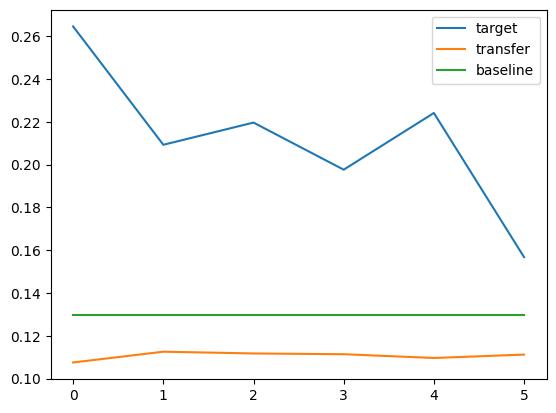

In [35]:
plt.plot(target_RMSEs,label='target')
plt.plot(transfer_RMSEs,label='transfer')
plt.plot(baseline_RMSEs, label='baseline')
plt.legend()

In [36]:
column_names = []

for i in range(len(training_months)+1):
    column_names.append(str(i) + 'm')

In [37]:
all_metrics = pd.DataFrame([baseline_RMSEs, target_RMSEs, transfer_RMSEs,
                            baseline_MBEs, target_MBEs, transfer_MBEs,
                            baseline_MAEs, target_MAEs, transfer_MAEs, 
                            target_best_epochs, transfer_best_epochs],
                           columns=column_names, index=['Baseline RMSE', 'Target RMSE', 'Transfer RMSE', 
                                                        'Baseline MBE', 'Target MBE', 'Transfer MBE', 
                                                        'Baseline MAE', 'Target MAE', 'Transfer MAE', 
                                                        'Target epoch', 'Transfer epoch']).transpose()

all_metrics['Target epoch'] = all_metrics['Target epoch'].astype(int)
all_metrics['Transfer epoch'] = all_metrics['Transfer epoch'].astype(int)
all_metrics

,Baseline RMSE,Target RMSE,Transfer RMSE,Baseline MBE,Target MBE,Transfer MBE,Baseline MAE,Target MAE,Transfer MAE,Target epoch,Transfer epoch
0m,0.130,0.264,0.108,0.000,0.129,0.007,0.054,0.148,0.054,0,0
1m,0.130,0.209,0.113,0.000,0.082,0.015,0.054,0.100,0.056,18,909
2m,0.130,0.220,0.112,0.000,0.094,0.017,0.054,0.104,0.055,12,528
3m,0.130,0.198,0.111,0.000,0.080,0.014,0.054,0.097,0.055,9,369
4m,0.130,0.224,0.110,0.000,0.099,0.015,0.054,0.107,0.054,7,896
5m,0.130,0.157,0.111,0.000,0.058,0.019,0.054,0.078,0.055,6,539


In [38]:
if distance and weather_variables:
    all_metrics.to_csv('../results/NL/' + 'summary_table_' + data_name + '.csv')
elif distance:
    all_metrics.to_csv('../results/NL/' + 'summary_table_' + data_name + '.csv')
elif seasonal:
    all_metrics.to_csv('../results/NL/' + 'summary_table_' + data_name + '.csv')
elif weather_variables:
    all_metrics.to_csv('../results/NL/' + 'summary_table_' + data_name + '.csv')
else:
    all_metrics.to_csv('../results/NL/' + 'summary_table_' + data_name + '.csv')

In [39]:
data_name

'amstelveen_0_feb_2021'